In [ ]:
# -*- coding: utf-8 -*-

### Imports ###
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
!pip install matching
from matching.games import StableMarriage

matplotlib.rcParams["figure.dpi"] = 300  # highres display
from IPython.display import clear_output
from time import sleep

In [ ]:
### Helper Functions ###
def HammingDistance(x, y):
    "gives Hamming distance b/w #x and #y"
    count = 0
    if len(x) == len(y):
        for _ in range(len(x)):
            if x[_] != y[_]:
                count += 1
    else:
        raise ValueError("Incorrect dimensions of input vectors")
    return count / len(x)

def SyncUpdate(W, x, bias):
    "returns the synchronously updated neuron values #x using #W"
    ### choose preferred #activation function {tanh, sign, sigmoid}
    return np.sign(np.dot(W, x) - bias )


def AsyncUpdate(W, x, bias, updates=1):
    "returns the asynchronously updated neuron values #x using #W"
    for _ in np.random.randint(low=0, high=len(x), size=updates):
        x[_] = Step(np.dot(W[_, :], x) - bias[_])
    return x


def ProbUpdate(W, x, bias, beta=1000, updates=10):
    "returns the Metropolis updated neuron values #x using #W. #beta is the temperature parameter"
    for _ in np.random.randint(0, len(x), size=updates):
        h_ = (np.dot(W[_, :], x)- bias[_])/len(x)
        x[_] = np.random.choice([+1, 0], p=[Sigmoid(beta*h_), Sigmoid(-beta*h_)])
    return x


def Energy(W, x, bias):
    "return the energy of a particular configuration #x of neuron values"
    return -0.5 * (1 / len(x)) * ( np.dot(x, np.dot(W, x)) - np.dot(bias,x))

def Step(x):
    if x>0: return 1
    if x<=0: return 0
    
def Sigmoid(x):
    "return the sigmoid of x#"
    return 1 / (1 + np.exp(-x))

def RogueCoupleCheck(matching_vector,W_boy, W_girl):
    """ return thr number of rogue couples under current matching ~
        matching_vector: the matching grid in !d vector form 
        W_boy: prefernce matrix of Boys
        W_girl: prefernce matrix of Girls """

    N = len(matching_vector)
    n = int(np.sqrt(N))
    matching = matching_vector.reshape((n,n))

    rogue_couples = 0
    for girl in range(n):
      boy_pref = np.where(matching[:, girl]==1)[0]
      if len(boy_pref) != 1: raise RuntimeError("invalid matching")
      for boy in range(n):
        girl_pref = np.where(matching[boy, :]== 1)[0]
        if len(girl_pref) != 1: raise RuntimeError('invalid matching')
        ## assuming lower weight => higher prefernce ~ 
        if W_girl[girl, boy_pref] > W_girl[girl, boy]:
          if W_boy[boy, girl_pref] > W_boy[boy, girl]:
            rogue_couples += 1 
    
    return rogue_couples    



In [ ]:
def Run(steps, x0, W, bias, update_rule= 'AsyncUpdate', skip_steps = 10):
    """ function to update the configuration of network
        steps: no. of steps of iteraation
        x0: input initial matchings of network as a 1d-vector
        W: input weight matrix
        update_rule: specify update rule
        skip steps: no. steps skipped while visualization"""
    n = int(np.sqrt(len(x0))) ## dimension of grid
    E = [] ## list to store energy
        
    xticklabels, yticklabels = [],[]
    for _ in range(n): 
      xticklabels.append("girl"+str(_+1))
      yticklabels.append("boy"+str(_+1))

    for _ in range(steps):
        if update_rule== 'SyncUpdate' : x0 = SyncUpdate(W, x0, bias)
        elif update_rule== 'AsyncUpdate' : x0 = AsyncUpdate(W, x0, bias, updates= 100)
        elif update_rule== 'ProbUpdate' : x0 = ProbUpdate(W, x0, bias, updates=100)
        E.append(Energy(W, x0, bias))

        ## visualization sub-routine ~ 
        if (_%skip_steps == 0):
            clear_output(wait= True)
            plt.figure(figsize= (12,10))
            plt.subplot(221)
            plt.title("Current Matchings: ")
            sns.heatmap(x0.reshape(n,n),xticklabels= xticklabels, yticklabels= yticklabels, cbar= False)
            plt.subplot(222)
            plt.title('Energy')
            plt.plot(np.linspace(0,len(E),len(E)),E)
            plt.xlabel('Iterations ->')
            plt.show()
            sleep(0.01)

    return x0


<Figure size 864x720 with 0 Axes>

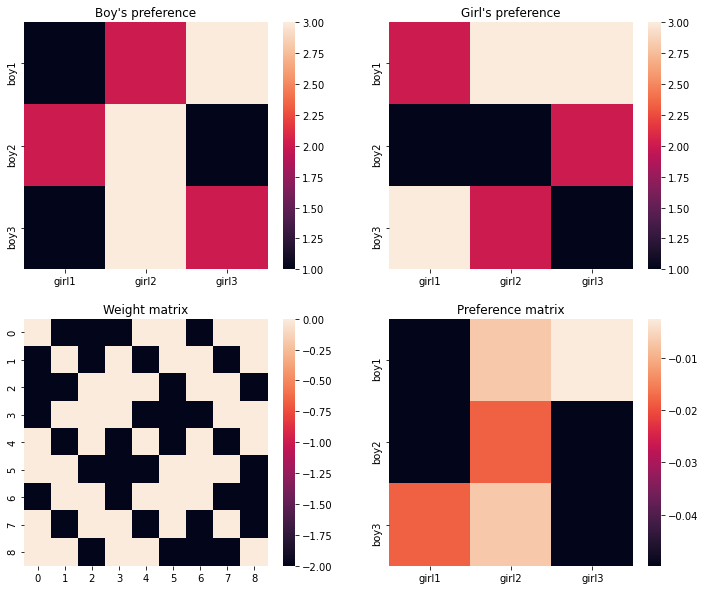

In [ ]:
### Initializations ###

## size of matching n ~
n= 3
## no. of neurons N ~
N = n*n

## initialize prefernce table ~
boy_pref = np.array([[1,2,3],[2,3,1],[1,3,2]])
girl_pref = np.array([[2,1,3],[3,1,2],[3,2,1]])

plt.figure(figsize= (12,10))

## construct weight matrix W ~
W = np.zeros((N,N))
## set W for legal moves ~
for i in range(n):
    for j in range(n):
        index = i*n + j
        for _ in range(j+1, n): W[index, index-j+_] = W[index-j+_,index] = -2
        for _ in range(i+1, n): W[index, _*n+ j] = W[_*n+ j, index] = -2

## construt bias according to prefernce table ~
bias = np.zeros(N)
for i in range(n):
    for j in range(n):
        bias[i*n + j] = -1*np.exp(-1* boy_pref[i,j]- 1*girl_pref[j,i])
        
## print W and Preference matrix ~
boylabels, girllabels = [],[]
for _ in range(n): 
  girllabels.append("girl"+str(_+1))
  boylabels.append("boy"+str(_+1))  
plt.figure(figsize=(12,10))
plt.subplot(221)
plt.title("Boy's preference")
sns.heatmap(boy_pref,xticklabels = girllabels, yticklabels= boylabels)
plt.subplot(222)
plt.title("Girl's preference" )
sns.heatmap(girl_pref.transpose() ,xticklabels = girllabels, yticklabels= boylabels)
plt.subplot(223)
plt.title('Weight matrix')
sns.heatmap(W)
plt.subplot(224)
plt.title('Preference matrix')
sns.heatmap(bias.reshape((3,3)),xticklabels = girllabels, yticklabels= boylabels)

## random initial config ~
x0 = np.random.choice([0,1], N)

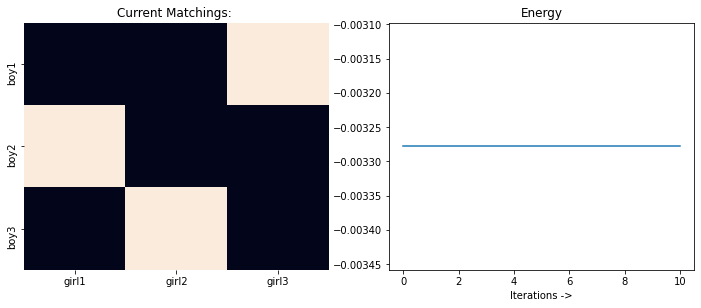

2

In [ ]:
match = Run(10, np.array([0,1,1,1,1,0,0,1,1]), W, bias, update_rule='AsyncUpdate', skip_steps= 1)
RogueCoupleCheck(match, boy_pref, girl_pref)

In [ ]:
RogueCoupleCheck(np.array([0,1,0,1,0,0,0,0,1]), boy_pref, girl_pref)

0